In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
import nclcmaps as nclc
from utils import add_days_to_date

In [2]:
# Set up paths
server = 'great'
path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [3]:
arcase_lst = ['feb1998', 'feb2010']
era5_data = []
wrf_data = []

for i, arname in enumerate(arcase_lst):
    # import configuration file for case study choice
    yaml_doc = '../data/config_files/ar_casestudy.yml'
    config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
    ar_dict = config[arname]

    year = ar_dict['year']
    month = ar_dict['month']
    start_date = ar_dict['start_date']
    end_date = add_days_to_date(ar_dict['end_date'], 1)
    print(start_date, end_date)

    # Select lat/lon grid
    lonmin = 20
    lonmax = 95
    latmin = 10
    latmax = 60
    
    ### ERA5 DATA ###
    ## ivt data
    rename_dict_ivt = {'p71.162': 'ivte', 
                       'p72.162': 'ivtn',
                       'latitude': 'lat',
                       'longitude': 'lon'}

    filepath = path_to_data + 'ERA5/ivt/6hr/era5_hma_05dg_6hr_ivt_' + str(year) + '.nc'
    ds = xr.open_dataset(filepath)
    ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date))
    ds = ds.rename(rename_dict_ivt)
    ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2))
    ds = ds.sel(time=ds.time.dt.hour == 0) # select the 00 UTC hour 

    ## upper level data
    rename_dict_upper = {'z': 'H', 
                         'u': 'U250', 
                         'v':'V250', 
                         'q': 'QV',
                         'latitude': 'lat',
                         'longitude': 'lon'}

    filepath = path_to_data + 'ERA5/huvq/6hr/era5_hma_05dg_6hr_huvq_' + str(year) + '.nc'
    ds2 = xr.open_dataset(filepath)
    ds2 = ds2.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date), level=250.)
    ds2 = ds2.rename(rename_dict_upper)
    ds2 = ds2.assign(H=lambda ds2: ds2.H/(9.80665)) # convert to geopotential height (m)
    ds2 = ds2.sel(time=ds2.time.dt.hour == 0) # select the 00 UTC hour 
    
    era5_data.append([ds, ds2])
    
    ### WRF DATA ###
    domains = ['d01', 'd01', 'd02', ]
    varname_lst = ['ivt', 'geopotential', 'prec']
    res_lst = ['3hr', '3hr', '3hr']

    ## loop through each ds
    ds_lst = []
    for j, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
        if server == 'great':
            data_path = path_to_data + 'wrf_hasia/'
        else:
            data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start_date, end_date))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        if varname == 'prec':
            # Calculate precipitation rate
            ds = ds.shift(time=-1) - ds # if in xarray

        ds = ds.sel(time=ds.time.dt.hour == 0) # select the 00 UTC hour 

        ds_lst.append(ds)
    wrf_data.append(ds_lst)

1998-02-12 1998-02-16
/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_1998.nc
/home/nash/DATA/data/wrf_hasia/d01/geopotential/3hr/tmp_1998.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_1998.nc
2010-02-05 2010-02-09
/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d01/geopotential/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc


### WRF Terrain

In [4]:
wrf_filenames = ar_dict['wrf_files2'] 
wrfin = nc.Dataset(wrf_filenames[0])
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height


### Plot

We want a four column plot with 5 rows 
- Feb 2010 will be on the 00 hour of each day of event
- Feb 1998 will be on the 06 hour of each day of event
- Columns 1 & 2 will be ERA5 IVT and Geopotential Height
- Columns 3 & 4 will be WRF precipitation and IVT
- Latitude labels will be on the far left and far right
- Two colorbars on the bottom - one for IVT, one for precip

In [35]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# extent of maps
ext1 = [lonmin,lonmax,latmin,latmax]
ext2 = [69.0, 89.0, 28.0, 43.]

# Set tick/grid locations for ivt
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+10,10)

# Set tick/grid locations for precip
dx2 = np.arange(round(ext2[0], 0),round(ext2[1]+4, 0),4)
dy2 = np.arange(round(ext2[2], 0),round(ext2[3]+2, 4),4)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
letter_lst1 = [letter_lst[0:5], letter_lst[5:10]]
letter_lst2 = [letter_lst[10:15], letter_lst[15:20]]

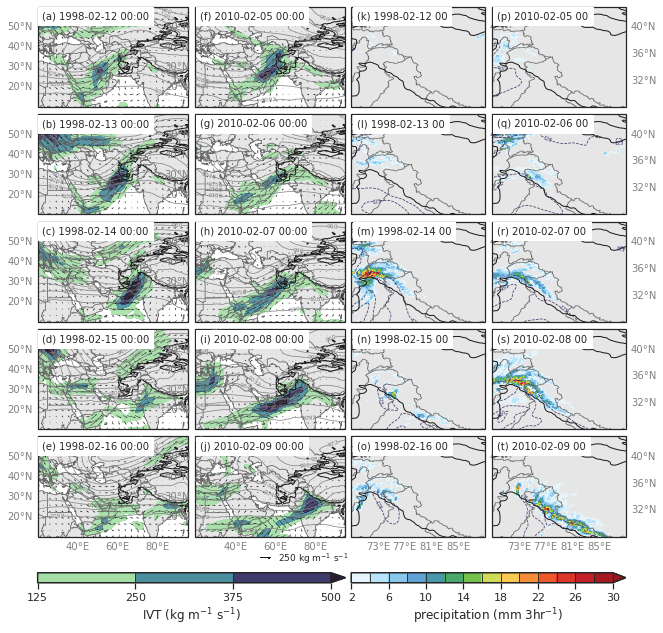

In [36]:
filepath = path_to_figs + 'synoptic_daily.png'
nrows = 5
ncols = 4

col_lbl1 = ['(a)', '(b)', '(c)', '(d)', '(e)']
col_lbl2 = ['(f)', '(g)', '(h)', '(i)', '(j)']
col_lbl3 = ['(k)', '(l)', '(m)', '(n)', '(o)']
col_lbl4 = ['(p)', '(q)', '(r)', '(s)', '(t)']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
## IVT
axgr = AxesGrid(fig, [0.1, 0.1, 0.5, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 2), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.4, cbar_size='5%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)
## prec
axgr2 = AxesGrid(fig, [0.375, 0.1, 0.5, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 2), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.4, cbar_size='5%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)

xpt = 5
ypt = 159
################################
########## IVT PLOTS ###########
################################

# hack for tick labels to only label far left and bottom grids
share_bottom = [False]*(nrows-1) + [True] + [False]*(nrows-1) + [True]
share_left = [True]*nrows + [False]*nrows 

for j, data in enumerate(era5_data):
    axgr_sub = axgr[j*nrows:nrows*(j+1)]
    for k, ax in enumerate(axgr_sub):
        ds = data[0]
        # lat/lon arrays
        lats = ds.lat.values
        lons = ds.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,
                          left_lats=share_left[k], right_lats=False, bottom_lons=share_bottom[k])

        # Contour Filled  
        # IVT (filled contour)
        uvec = ds.ivte.isel(time=k).values
        vvec = ds.ivtn.isel(time=k).values
        ivt = ds.ivt.isel(time=k).values
        ivt_sm = gaussian_filter(ivt, sigma=1.5)
        cflevs = np.arange(125, 510, 125)
        cf = ax.contourf(lons, lats, ivt_sm, transform=datacrs,
                         levels=cflevs, cmap=cmo.deep, alpha=0.9, extend='max') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=50, units='xy')

        # Contour Lines
        # 250-hPa Heights
        ds2 = data[1]
        hgts = ds2.H.isel(time=k).values/10. #convert to dekameters
        clevs = np.arange(840, 1280, 12)
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='grey', linewidths=0.7, linestyles='solid')
        kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 10, 'fmt': '%i',
                      'rightside_up': True, 'use_clabeltext': True}
        plt.clabel(cs, **kw_clabels)

        # Contour Lines (terrain)
        terclevs=np.array([1000])
        terlons = terrain.XLONG.values
        terlats = terrain.XLAT.values
        cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                        linestyles='solid', transform=datacrs)

        # subtitles
        date = ds.time[k].values

        t = pd.to_datetime(str(date)) 
        timestring = t.strftime('%Y-%m-%d %H:00')
        ttl = "({0}) ".format(letter_lst1[j][k]) + timestring
    #     ax.set_title(timestring, loc='left',fontsize=13)
        # ax.annotate(timestring, (5, 90), xycoords='axes points', fontsize=12.,
        #                 backgroundcolor='white')

        ax.text(0.03, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')

# quiver key
qk = ax.quiverkey(Q, 0.5, -0.21, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 9.0})



################################
########## PREC PLOTS ##########
################################

# hack for tick labels to only label far left and bottom grids
share_bottom = [False]*(nrows-1) + [True] + [False]*(nrows-1) + [True]
share_right_new = [False]*nrows + [True]*nrows

for j, ds in enumerate(wrf_data):
    axgr_sub = axgr2[j*nrows:nrows*(j+1)]
    for k, ax in enumerate(axgr_sub):
        ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=False, right_lats=True, 
                          bottom_lons=share_bottom[k], mask_ocean=False)


        # Contour Filled (prec)
        data = ds[2]
        prec = data.prec.isel(time=k).values
        cflevs = np.arange(2, 32, 2)
        cmap = nclc.cmap('WhiteBlueGreenYellowRed')
        cf = ax.contourf(data.lon.values, data.lat.values, prec, transform=datacrs,
                         levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

        # Contour Lines (IVT)
        data = ds[0]
        ivt = data.ivt.isel(time=k).values
        ivt_sm = gaussian_filter(ivt, sigma=2.0)
        ivtclevs=np.array([125, 250, 375, 500])
        kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                      'rightside_up': True, 'use_clabeltext': True}
        cl = ax.contour(data.lon.values, data.lat.values, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
                        linestyles='dashed', transform=datacrs)
        plt.clabel(cl, **kw_clabels)

        # Contour Lines (terrain)
        terclevs=np.array([1000])
        terlons = terrain.XLONG.values
        terlats = terrain.XLAT.values
        cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                        linestyles='solid', transform=datacrs)

        # subtitles
        date = data.time[k].values
        t = pd.to_datetime(str(date)) 
        timestring = t.strftime('%Y-%m-%d %H')
        ttl = "({0}) ".format(letter_lst2[j][k]) + timestring
        ax.text(0.04, 0.9525, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)

    # Colorbar (single)
    cb = fig.colorbar(cf, axgr2.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('precipitation (mm 3hr$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()